# Chapter 6: Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score

1. The approximate depth of a decision tree trained on 1,000,000 instances without restrictions is $log_{2}(1,000,000)\approx20$

In [2]:
np.log2(1_000_000)

19.931568569324174

2. The Gini Impurity generally decreases, although not always, for example:

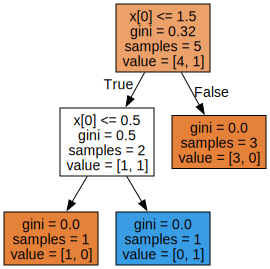

In [3]:
X = np.arange(5).reshape(-1, 1)
y = np.array(["A", "B", "A", "A", "A"])

tree_reg = DecisionTreeClassifier()
tree_reg.fit(X, y)

export_graphviz(
    tree_reg,
    out_file=str("models/regression_tree.dot"),
    filled=True,
)
Source.from_file("models/regression_tree.dot")

3. If a decision tree is overfitting decreasing `max_depth` will regularize the model.
4. Decision trees are invariant to feature scaling, so this will not help an underfitting decision tree.
5. A decision tree has a training complexity of $O(n × m log2(m))$, where $n$ is the number of features and $m$ is the number of instances. So if it takes one hour to train a decision tree on a training set containing one million instances, it will take roughly 11 hours & 40 minutes to train on a training set of ten million instances:


In [4]:
(10_000_000 * np.log2(10_000_000)) / (1_000_000 * np.log2(1_000_000))

11.666666666666666

6. However, if you double the number of features, training will take roughly twice as long.

## Training a decision tree on a moons dataset

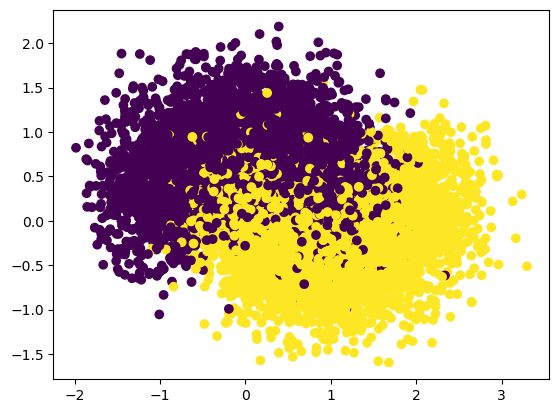

In [5]:
X, y = make_moons(n_samples=10_000, noise=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

In [6]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
dt.get_n_leaves()

1196

In [8]:
model = GridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
        "max_leaf_nodes": range(2, 40),
    },
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
)

model.fit(X_train, y_train)

Fitting 5 folds for each of 1102 candidates, totalling 5510 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 30),
                         'max_leaf_nodes': range(2, 40)},
             scoring='accuracy', verbose=1)

In [9]:
model.best_score_

0.8552

In [10]:
best_params = model.best_params_
best_params

{'max_depth': 7, 'max_leaf_nodes': 16}

In [11]:
accuracy_score(y_test, model.predict(X_test))

0.8568

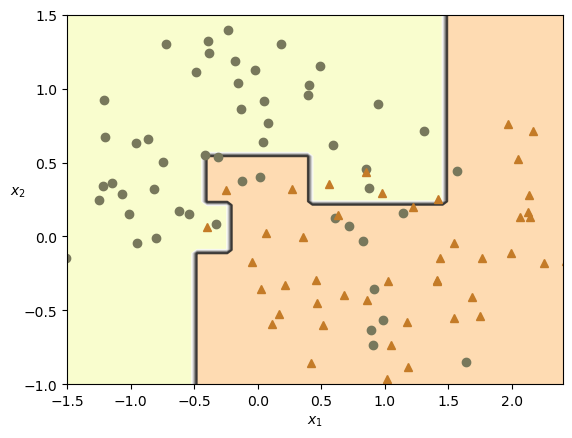

In [12]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[cmap][idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)


plot_decision_boundary(
    model, X[:100], y[:100], axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia"
)
plt.show()

## 8. Growing a forest

In [13]:
class MyRandomForrestClassifier:

    def __init__(self, max_depth, max_leaf_nodes):
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes

    def fit(self, X, y):

        self.trees_ = []

        rs = ShuffleSplit(n_splits=1_000, train_size=100)
        for train_index, test_index in rs.split(X):

            self.trees_.append(
                DecisionTreeClassifier(
                    max_depth=self.max_depth,
                    max_leaf_nodes=self.max_leaf_nodes,
                )
            )
            self.trees_[-1].fit(X[train_index], y[train_index])

    def predict(self, X):
        predictions = []
        for tree in self.trees_:
            predictions.append(tree.predict(X))
        return mode(np.vstack(predictions)).mode

In [14]:
model = MyRandomForrestClassifier(**best_params)
model.fit(X_train, y_train)

In [15]:
accuracy_score(y_test, model.predict(X_test))

0.8668

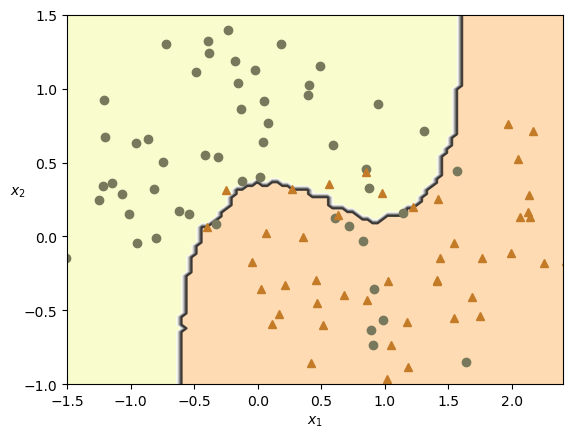

In [16]:
plot_decision_boundary(
    model, X[:100], y[:100], axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia"
)
plt.show()